In [56]:
#imports needed
import numpy as np
import astropy.units as u
import astropy.table as tbl
import matplotlib.pyplot as plt

from ReadFile import Read
from CenterOfMass import CenterOfMass
from astropy.constants import G

In [71]:
class MassProfile:
# Class to define 

    def __init__(self, galaxy, snap):
        
        ''' 
        class to find the mass profile of a galaxy 
            
            parameters
            
                galaxy: 
                a string with galaxy name (like MW, M31, etc)
                snap: Snapshot number
            '''
        
        # adding a string of the filename to the value 000
        ilbl = '000'+str(snap)
        # removing all digits except the last 3 
        ilbl = ilbl[-3:]
        self.filename = "%s_"%(galaxy)+ilbl+'.txt'
     
        # reading the data in the given file using previously defined Read function
        self.time, self.total, self.data = Read(self.filename)                                                                                             

        # storing the positions, velocities, & mass
        self.x = self.data['x']*u.kpc
        self.y = self.data['y']*u.kpc
        self.z = self.data['z']*u.kpc
        self.vx = self.data['vx']*u.km/u.s
        self.vy = self.data['vy']*u.km/u.s
        self.vz = self.data['vz']*u.km/u.s
        self.m = self.data['m']
        
        #set the galaxy name as a global property
        self.gname = galaxy
        
    def MassEnclosed(self, ptype, radii):
        '''
        this function will compute the enclosed mass 
        for a given radius of the COM position for a particular galaxy's component.

        inputs:
            ptype:
                the particle type to use for COM calculations (1, 2, 3)
            radii: 
                an array of radii in magnitude

        outputs: 
            masses_enclosed: 
                an array of enclosed mass at each particular radius specified
                in units of M_sun 

        '''
        #creating the CenterOfMass objects and calling previously defined COM_P
        COM = CenterOfMass(self.filename, ptype)
        COM_p = COM.COM_P(0.1)
        print(COM_p)
        
        
        index = np.where(self.data['type'] == ptype)
        
        #loop over the radius array to define particles that are enclosed within the radius given
        
        self.m_new = self.m[index]
        
        masses_enclosed = np.zeros(len(radii))
        for i in range(len(radii)):
            
            distance_magnitude = np.sqrt((self.x[index]-COM_p[0])**2 
                                         +(self.y[index]-COM_p[1])**2 
                                         +(self.z[index]-COM_p[2])**2)
            
            enclosed_index = np.where(distance_magnitude/u.kpc < radii[i])
            
            #storing the sum of masses of the particles within the particular radius
            masses_enclosed[i]= sum(self.m_new[enclosed_index])
            
        return masses_enclosed * 1e10 *u.Msun
    
    def MassEnclosedTotal(self, radii):
        ''' this calculates the total enclosed mass from each particle type
        
        inputs:
            radii: 
                array of radii to calculate the enclosed mass at each point
        
        outputs:
            total_mass: 
                array of the toal mass enclosed at each radii in M_sun
        
        '''
        
        # calulating the mass enclosed for each particle type
        halo_mass = self.MassEnclosed(1, radii)
        disk_mass = self.MassEnclosed(2, radii)
        if self.gname != 'M33': # M33 doesn't have a buldge mass, so we skip it
            bulge_mass = self.MassEnclosed(3, radii)  
            total_mass = halo_mass + disk_mass + bulge_mass
        else:
            total_mass = halo_mass + disk_mass
            
        return total_mass
    
    def HernquistMass(self, radii, a, M_halo):
        '''
        computes the mass enclosed within a particular radius
        
        inputs:
            radius: 'array'
                an array of radii values
            a: 'float'
                hernquist scale factor
            M_halo: 'array'
                the halo mass of the galaxy
            
        outputs:
            M: the mass enclosed at a given radius in M_sun
            
        '''
        
        # hernquist mass profile
        
        M = (M_halo*radii**2/(a+radii)**2 )*u.Msun
            
        return M
    
    def CircularVelocity(self, ptype, radii, G):
        '''
        this function calculates the circular speed at each particular radii.
        
        inputs:
            ptype: 
                particle type (as a float)
            radii: 
                an array of radii for the circular speed to be calculated at 
            G: 
                gravitational constant in kms units
        
        output:
            Vcirc:
                an array of circular speeds with units km/s, rounded to two decimal places
        
        '''
        
        G = G.to(u.kpc*u.km**2/u.s**2/u.Msun) # converting the units
        
        # finding mass enclosed
        M_enclosed = self.MassEnclosed(ptype, radii)
        
        # applying circular speed formula
        Vcirc = np.round(np.sqrt(G*M_enclosed/(radii*u.kpc)), 2)
        
        #print(Vcirc)
        
        return Vcirc
    
    def CircularVelocityTotal(self, radii, G):
        '''
        this function calculates the total circular velocity 
        representing the total Vcirc created by all the galaxy components
        at each particular radius from the input array
        
        inputs:
            radii:
                an array of radii
            
            G:
                gravitational constant in kms units
        
        outputs:
            total_Vcirc:
                an array of circular velocity (in units of km/s)
                
        '''
        
        # calculating circular velocity for each of the particle types
        halo_Vcirc = self.CircularVelocity(1, radii, G)
        disk_Vcirc = self.CircularVelocity(2, radii, G)
        if self.gname != 'M33': # M33 doesn't have a buldge mass, so we skip it
            bulge_Vcirc = self.CircularVelocity(3, radii, G)  
            total_Vcirc = halo_Vcirc + disk_Vcirc + bulge_Vcirc
        else:
            total_Vcirc = halo_Vcirc + disk_Vcirc
            
        return total_Vcirc
    
    def HernquistVcirc(self,radius,a, M_halo, G):
        '''
        this function computes the circular speed using the hernquist mass profile
        
        inputs:
            radius:
                an array of radii for the circular speed to be computed at
            a: 
                Hernquist scale factor (float)
            M_halo:
                an array of the halo mass of the galaxy
            
        
        '''
        
        G = G.to(u.kpc*u.km**2/u.s**2/u.Msun) # converting units
        
        Mass_Hern = self.HernquistMass(radius,a,M_halo) # calculating the hernquist mass
        
        Vcirc = np.round(np.sqrt(G*Mass_Hern/(radius*u.kpc)), 2) #round and add units
        
        print(Vcirc)
        
        return Vcirc
    

# Milky Way Mass Profile

In [72]:
MW = MassProfile("MW", 0) # initializing MW classs

In [73]:
 r = np.arange(0.1, 30.5, 0.5) # radius range we are using up to 30kpc


# calculating enclosed mass for each galaxy component for each radius
enclosed_mass_MW_halo = MW.MassEnclosed(1,r)
enclosed_mass_MW_disk = MW.MassEnclosed(2,r)
enclosed_mass_MW_bulge = MW.MassEnclosed(3,r)

# calculating the total mass enclosed at each radius
total_mass_MW = MW.MassEnclosedTotal(r)


r_com 6.466908569995345
r com:  3.907887032207845
r com:  0.549113311071831
r com:  1.4611845632198588
r com:  1.35665650418262
r com:  0.8412018333105473
r com:  1.4779095535486781
r com:  1.6773430302594585
r com:  2.2806331826115778
r com:  2.74463148383224
r com:  2.930312984278641
r com:  3.32832919585482
r com:  3.588104751082138
r com:  3.610702375742955
[-1.9   2.62 -1.6 ] kpc
r_com 2.9501930277320705
r com:  3.1799740718728193
r com:  3.6504077061113005
r com:  3.851298082856057
r com:  3.881485248053005
[-2.07  2.95 -1.45] kpc
r_com 3.4283486839254285
r com:  3.5746333938913075
r com:  3.520121283345595
[-1.92  2.64 -1.32] kpc
r_com 6.466908569995345
r com:  3.907887032207845
r com:  0.549113311071831
r com:  1.4611845632198588
r com:  1.35665650418262
r com:  0.8412018333105473
r com:  1.4779095535486781
r com:  1.6773430302594585
r com:  2.2806331826115778
r com:  2.74463148383224
r com:  2.930312984278641
r com:  3.32832919585482
r com:  3.588104751082138
r com:  3.6107023

In [157]:
a = 40 # the estimated scale factor
hernquist_profile = MW.HernquistMass(r, a, sum(MW.m_new*1e12)) # finding the hernquist model halo mass enclosed

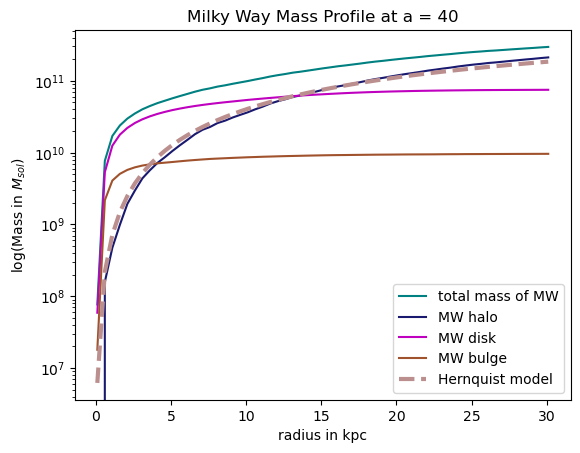

In [158]:
# plotting MW mass profile
plt.semilogy(r, total_mass_MW, label='total mass of MW', c='teal')
plt.semilogy(r, enclosed_mass_MW_halo, label='MW halo', c='midnightblue')
plt.semilogy(r, enclosed_mass_MW_disk, label='MW disk', c='m')
plt.semilogy(r, enclosed_mass_MW_bulge, label='MW bulge', c='sienna')
plt.semilogy(r,hernquist_profile, '--',label='Hernquist model', c='rosybrown', linewidth=3)

plt.ylabel('log(Mass in $M_{sol}$)')
plt.xlabel('radius in kpc')
plt.title("Milky Way Mass Profile at a = %s" % a)
plt.legend()


In [62]:
G

<<class 'astropy.constants.codata2018.CODATA2018'> name='Gravitational constant' value=6.6743e-11 uncertainty=1.5e-15 unit='m3 / (kg s2)' reference='CODATA 2018'>

In [63]:
# calculating the circular velocity at each radius for each galaxy component
velocity_MW_halo = MW.CircularVelocity(1, r, G)
velocity_MW_disk = MW.CircularVelocity(2, r, G)
velocity_MW_bulge = MW.CircularVelocity(3, r, G)

# calculating the circular velocity at each radius for total mass
total_velocity_MW = MW.CircularVelocityTotal(r, G)

r_com 6.466908569995345
r com:  3.907887032207845
r com:  0.549113311071831
r com:  1.4611845632198588
r com:  1.35665650418262
r com:  0.8412018333105473
r com:  1.4779095535486781
r com:  1.6773430302594585
r com:  2.2806331826115778
r com:  2.74463148383224
r com:  2.930312984278641
r com:  3.32832919585482
r com:  3.588104751082138
r com:  3.610702375742955
[-1.9   2.62 -1.6 ] kpc
r_com 2.9501930277320705
r com:  3.1799740718728193
r com:  3.6504077061113005
r com:  3.851298082856057
r com:  3.881485248053005
[-2.07  2.95 -1.45] kpc
r_com 3.4283486839254285
r com:  3.5746333938913075
r com:  3.520121283345595
[-1.92  2.64 -1.32] kpc
r_com 6.466908569995345
r com:  3.907887032207845
r com:  0.549113311071831
r com:  1.4611845632198588
r com:  1.35665650418262
r com:  0.8412018333105473
r com:  1.4779095535486781
r com:  1.6773430302594585
r com:  2.2806331826115778
r com:  2.74463148383224
r com:  2.930312984278641
r com:  3.32832919585482
r com:  3.588104751082138
r com:  3.6107023

# Milky Way Rotation Curve

In [155]:
a = 40 # scale factor for MW

# finding the hernquist model of circular velocity
hernquist_profile = MW.HernquistVcirc(r,a, sum(MW.m_new*1e12), G) 

[ 16.36  39.58  52.94  63.07  71.4   78.52  84.74  90.27  95.25  99.75
 103.87 107.65 111.14 114.36 117.35 120.14 122.74 125.17 127.45 129.58
 131.59 133.47 135.25 136.92 138.5  139.99 141.39 142.72 143.98 145.17
 146.29 147.36 148.37 149.32 150.23 151.09 151.9  152.67 153.4  154.09
 154.74 155.36 155.95 156.51 157.03 157.53 158.   158.45 158.87 159.27
 159.64 159.99 160.33 160.64 160.94 161.21 161.47 161.71 161.94 162.15
 162.35] km / s


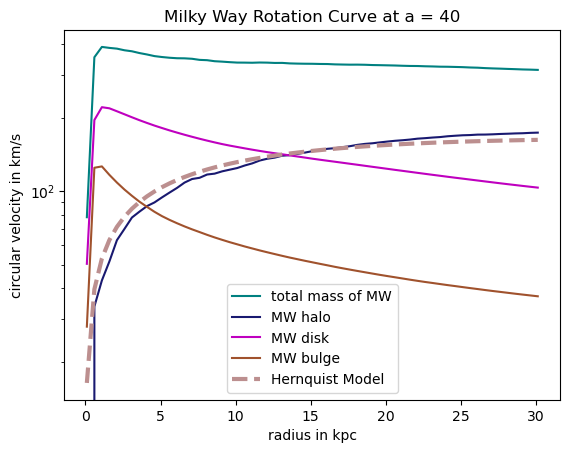

In [156]:
# plotting MW rotation curves
plt.plot(r, total_velocity_MW, label='total mass of MW', c='teal')
plt.plot(r, velocity_MW_halo, label='MW halo', c='midnightblue')
plt.plot(r, velocity_MW_disk, label='MW disk', c='m')
plt.plot(r, velocity_MW_bulge, label='MW bulge', c='sienna')
plt.plot(r,hernquist_profile, '--',label='Hernquist Model', c='rosybrown', linewidth=3)
plt.yscale('log')
plt.ylabel('circular velocity in km/s')
plt.xlabel('radius in kpc')
plt.title("Milky Way Rotation Curve at a = %s" % a)
plt.legend()

In [40]:
# initializing the M31 classs
M31 = MassProfile("M31", 0)
r = np.arange(0.25, 30.5, 0.5);print(r)

# calculating the enclosed mass for the galaxies component, at each radius
enclosed_mass_M31_halo = M31.MassEnclosed(1,r)
enclosed_mass_M31_disk = M31.MassEnclosed(2,r)
enclosed_mass_M31_bulge = M31.MassEnclosed(3,r)

#calculating total enclosed mass at each radius
total_mass_M31 = M31.MassEnclosedTotal(r)

[ 0.25  0.75  1.25  1.75  2.25  2.75  3.25  3.75  4.25  4.75  5.25  5.75
  6.25  6.75  7.25  7.75  8.25  8.75  9.25  9.75 10.25 10.75 11.25 11.75
 12.25 12.75 13.25 13.75 14.25 14.75 15.25 15.75 16.25 16.75 17.25 17.75
 18.25 18.75 19.25 19.75 20.25 20.75 21.25 21.75 22.25 22.75 23.25 23.75
 24.25 24.75 25.25 25.75 26.25 26.75 27.25 27.75 28.25 28.75 29.25 29.75
 30.25]
r_com 768.0033378059198
r com:  769.3088464280441
r com:  770.5107320468453
r com:  771.6633093741445
r com:  772.5857482962039
r com:  773.9311957565993
r com:  773.4882631902104
r com:  772.8592147887052
r com:  772.6276529188284
r com:  772.451971241578
r com:  772.6398098000546
r com:  772.7166517443308
[-377.03  611.41 -284.81] kpc
r_com 773.0189990729881
r com:  772.9744047761891
[-377.66  611.43 -284.64] kpc
r_com 772.548539731974
r com:  772.402698257896
r com:  772.3167063558096
[-377.23  610.98 -284.37] kpc
r_com 768.0033378059198
r com:  769.3088464280441
r com:  770.5107320468453
r com:  771.6633093741445
r 

# M31 Mass Profile

In [160]:
a = 60 # estimated scale factor for M31
hernquist_profile_M31 = M31.HernquistMass(r, a, sum(M31.m_new*1e12)) # finding hernquist model halo enclosed mass

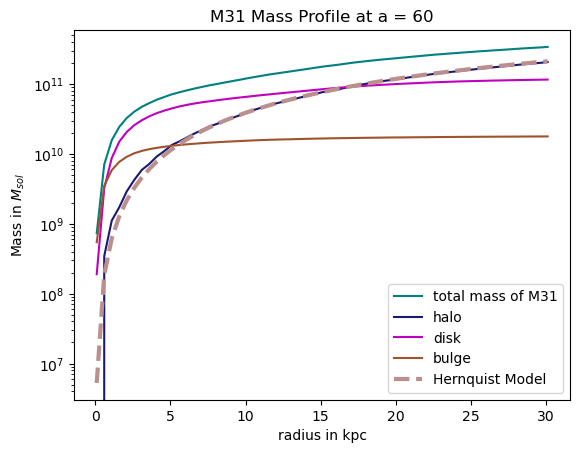

In [161]:
# plotting M31 mass profile
plt.semilogy(r, total_mass_M31, label='total mass of M31', c='teal')
plt.semilogy(r, enclosed_mass_M31_halo, label='halo', c='midnightblue')
plt.semilogy(r, enclosed_mass_M31_disk, label='disk', c='m')
plt.semilogy(r, enclosed_mass_M31_bulge, label='bulge', c='sienna')
plt.semilogy(r,hernquist_profile_M31, '--',label='Hernquist Model', c='rosybrown', linewidth=3)

plt.ylabel('Mass in $M_{sol}$')
plt.xlabel('radius in kpc')
plt.title("M31 Mass Profile at a = %s" % a)
plt.legend()

# M31 Rotation Curve

In [162]:
# calculating the circular velocity at each radius for each galaxy component
velocity_M31_halo = M31.CircularVelocity(1, r, G)
velocity_M31_disk = M31.CircularVelocity(2, r, G)
velocity_M31_bulge = M31.CircularVelocity(3, r, G)
# calculating the circular velocity at each radius for total mass
total_velocity_M31 = M31.CircularVelocityTotal(r, G)

r_com 768.0033378059198
r com:  769.3088464280441
r com:  770.5107320468453
r com:  771.6633093741445
r com:  772.5857482962039
r com:  773.9311957565993
r com:  773.4882631902104
r com:  772.8592147887052
r com:  772.6276529188284
r com:  772.451971241578
r com:  772.6398098000546
r com:  772.7166517443308
[-377.03  611.41 -284.81] kpc
r_com 773.0189990729881
r com:  772.9744047761891
[-377.66  611.43 -284.64] kpc
r_com 772.548539731974
r com:  772.402698257896
r com:  772.3167063558096
[-377.23  610.98 -284.37] kpc
r_com 768.0033378059198
r com:  769.3088464280441
r com:  770.5107320468453
r com:  771.6633093741445
r com:  772.5857482962039
r com:  773.9311957565993
r com:  773.4882631902104
r com:  772.8592147887052
r com:  772.6276529188284
r com:  772.451971241578
r com:  772.6398098000546
r com:  772.7166517443308
[-377.03  611.41 -284.81] kpc
r_com 773.0189990729881
r com:  772.9744047761891
[-377.66  611.43 -284.64] kpc
r_com 772.548539731974
r com:  772.402698257896
r com:  77

In [163]:
a = 60 #scale factor for M31
# finding the hernquist model of circular velocity
hernquist_profile_M31 = M31.HernquistVcirc(r,a, sum(M31.m_new*1e12), G)

[ 15.06  36.59  49.13  58.78  66.8   73.73  79.87  85.39  90.42  95.03
  99.3  103.26 106.95 110.41 113.67 116.73 119.63 122.36 124.96 127.42
 129.77 132.   134.13 136.16 138.1  139.95 141.72 143.42 145.05 146.61
 148.11 149.54 150.92 152.25 153.52 154.75 155.93 157.06 158.15 159.2
 160.21 161.19 162.12 163.03 163.9  164.74 165.55 166.33 167.09 167.81
 168.51 169.19 169.84 170.47 171.08 171.66 172.23 172.77 173.3  173.81
 174.3 ] km / s


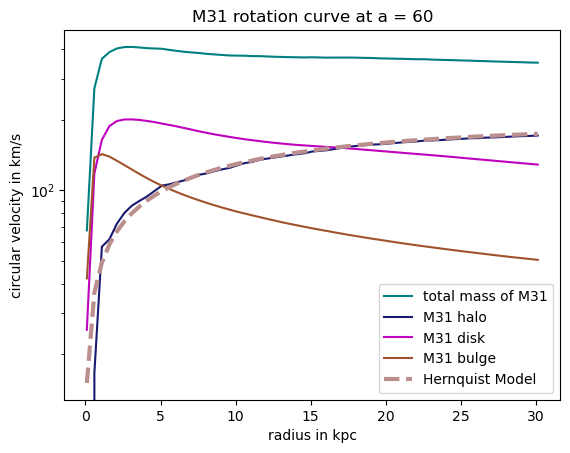

In [164]:
# plotting M31 rotation curves
plt.plot(r, total_velocity_M31, label='total mass of M31', c='teal')
plt.plot(r, velocity_M31_halo, label='M31 halo', c='midnightblue')
plt.plot(r, velocity_M31_disk, label='M31 disk', c='m')
plt.plot(r, velocity_M31_bulge, label='M31 bulge', c='sienna')
plt.plot(r,hernquist_profile_M31, '--',label='Hernquist Model', c='rosybrown', linewidth=3)
plt.yscale('log')
plt.ylabel('circular velocity in km/s')
plt.xlabel('radius in kpc')
plt.title("M31 rotation curve at a = %s" % a)
plt.legend()

# M33 Mass Profile

In [46]:
# initializing the M33 classs
M33 = MassProfile("M33", 0)
r = np.arange(0.25, 30.5, 0.5);print(r)

# calculating enclosed mass for each galaxy component for each particular radius
enclosed_mass_M33_halo = M33.MassEnclosed(1,r)
enclosed_mass_M33_disk = M33.MassEnclosed(2,r)
#calculating the total mass enclosed at each radius
total_mass_M33 = M33.MassEnclosedTotal(r)

[ 0.25  0.75  1.25  1.75  2.25  2.75  3.25  3.75  4.25  4.75  5.25  5.75
  6.25  6.75  7.25  7.75  8.25  8.75  9.25  9.75 10.25 10.75 11.25 11.75
 12.25 12.75 13.25 13.75 14.25 14.75 15.25 15.75 16.25 16.75 17.25 17.75
 18.25 18.75 19.25 19.75 20.25 20.75 21.25 21.75 22.25 22.75 23.25 23.75
 24.25 24.75 25.25 25.75 26.25 26.75 27.25 27.75 28.25 28.75 29.25 29.75
 30.25]
r_com 794.7599522252642
r com:  797.1462622825504
r com:  798.4172702000319
r com:  799.5656466282983
r com:  799.4977891500306
[-478.76  490.41 -411.68] kpc
r_com 798.9964294184706
r com:  798.9833407597501
[-476.22  491.44 -412.4 ] kpc
r_com 794.7599522252642
r com:  797.1462622825504
r com:  798.4172702000319
r com:  799.5656466282983
r com:  799.4977891500306
[-478.76  490.41 -411.68] kpc
r_com 798.9964294184706
r com:  798.9833407597501
[-476.22  491.44 -412.4 ] kpc


In [165]:
a = 80 # estimated scale factor
hernquist_profile_M33 = M33.HernquistMass(r, a, sum(M33.m_new*1e12)) # finding hernquist model halo mass encloseda = 80 # estimated scale factor
hernquist_profile_M33 = M33.HernquistMass(r, a, sum(M33.m_new*1e12)) # finding hernquist model halo mass enclosed

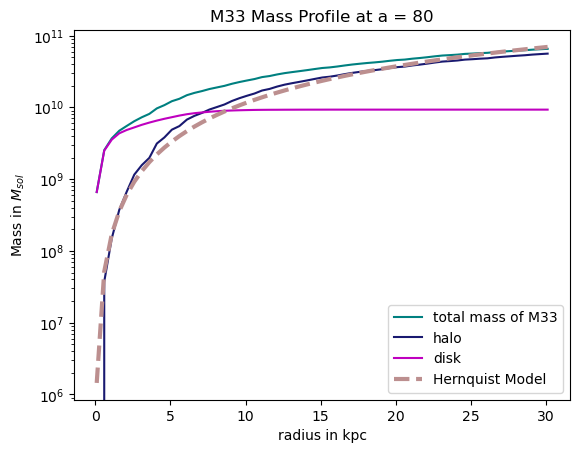

In [166]:
# plotting the M33 mass profile
plt.semilogy(r, total_mass_M33, label='total mass of M33', c='teal')
plt.semilogy(r, enclosed_mass_M33_halo, label='halo', c='midnightblue')
plt.semilogy(r, enclosed_mass_M33_disk, label='disk', c='m')
plt.semilogy(r,hernquist_profile_M33, '--',label='Hernquist Model', c='rosybrown', linewidth=3)

plt.ylabel('Mass in $M_{sol}$')
plt.xlabel('radius in kpc')
plt.title("M33 Mass Profile at a = %s" % a)
plt.legend()

# M33 Rotation Curve

In [49]:
# calculating the circular velocity at each particular radius for each galaxy component
velocity_M33_halo = M33.CircularVelocity(1, r, G)
velocity_M33_disk = M33.CircularVelocity(2, r, G)
# calculating the circular velocity at each radius for total mass
total_velocity_M33 = M33.CircularVelocityTotal(r, G)

r_com 794.7599522252642
r com:  797.1462622825504
r com:  798.4172702000319
r com:  799.5656466282983
r com:  799.4977891500306
[-478.76  490.41 -411.68] kpc
r_com 798.9964294184706
r com:  798.9833407597501
[-476.22  491.44 -412.4 ] kpc
r_com 794.7599522252642
r com:  797.1462622825504
r com:  798.4172702000319
r com:  799.5656466282983
r com:  799.4977891500306
[-478.76  490.41 -411.68] kpc
r_com 798.9964294184706
r com:  798.9833407597501
[-476.22  491.44 -412.4 ] kpc


In [168]:
a = 80 # the scaled factor
# finding the hernquist model of circular velocity
hernquist_profile_M33 = M33.HernquistVcirc(r,a, sum(M33.m_new*1e12), G)

[ 7.9  19.22 25.86 31.   35.3  39.04 42.37 45.39 48.15 50.7  53.07 55.29
 57.37 59.33 61.18 62.94 64.61 66.2  67.71 69.16 70.54 71.87 73.14 74.36
 75.54 76.66 77.75 78.8  79.81 80.78 81.72 82.63 83.5  84.35 85.17 85.97
 86.73 87.48 88.2  88.9  89.57 90.23 90.87 91.49 92.09 92.67 93.23 93.78
 94.31 94.83 95.34 95.82 96.3  96.76 97.21 97.65 98.07 98.49 98.89 99.28
 99.66] km / s


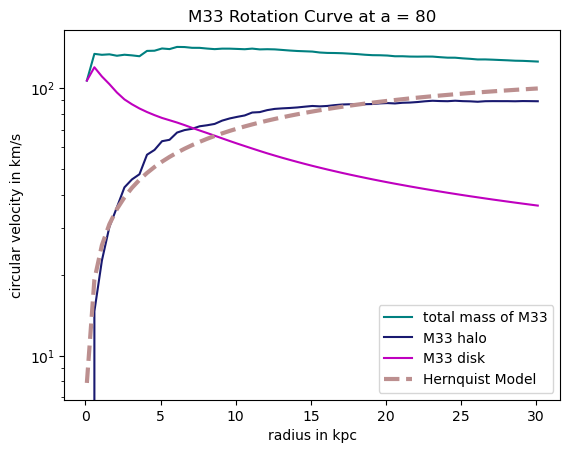

In [170]:
# plotting the M33 rotation curve
plt.plot(r, total_velocity_M33, label='total mass of M33', c='teal')
plt.plot(r, velocity_M33_halo, label='M33 halo', c='midnightblue')
plt.plot(r, velocity_M33_disk, label='M33 disk', c='m')
plt.plot(r,hernquist_profile_M33, '--',label='Hernquist Model', c='rosybrown', linewidth=3)
plt.yscale('log')
plt.ylabel('circular velocity in km/s')
plt.xlabel('radius in kpc')
plt.title("M33 Rotation Curve at a = %s" % a)
plt.legend()